## Vectorstores and Embeddings


In [ ]:
%pip install openai -q
%pip install langchain langchain-community langchain-openai -q

# for loadin the pdf documents
%pip install pypdf -q

In [ ]:
import os
import openai

from langchain_community.document_loaders import PyPDFLoader

In [ ]:
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

### Download the sources data


In [ ]:
!git clone https://gitlab.com/sanjeev.bhandari/files-collection.git

fatal: destination path 'files-collection' already exists and is not an empty directory.


## Load Documents Using Document Loader

We cannot pass a list of paths directly into the PyPDFLoader, as it expects a single file or URI for each PDF. Therefore, we define individual loaders for each file in a list, which then loads the PDFs and stores them in a single list variable.

In [ ]:
loaders = [
    # duplicate documents on purpose -messy data
    PyPDFLoader("/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture02.pdf"),
    PyPDFLoader("/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture03.pdf")
]

# store all docs in same list
docs = []

for loader in loaders:
  docs.extend(loader.load())

print(">>> Length of the docs: ", len(docs))
print(">>> Sample page content: ", docs[0].page_content[:100])
print(">>> Sample page metadata: ", docs[0].metadata)

>>> Length of the docs:  78
>>> Sample page content:  MachineLearning-Lecture01  
Instructor (Andrew Ng):  Okay. Good morning. Welcome to CS229, the machi
>>> Sample page metadata:  {'source': '/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf', 'page': 0}


### Splitter


In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=150
)

# split all the docs fro lis
splits = text_splitter.split_documents(docs)
print("Total chunks after split: ", len(splits))

Total chunks after split:  209


### Text Embeddings

Once the documents are divided into chunks, the subsequent task involves creating embeddings for these text segments.
- Embedding vectors encapsulate the semantic essence of text or content.
- Texts sharing similar content will exhibit analogous vectors.

Explore the various embedding services incorporated into LangChain in the [LangChain documentation](https://python.langchain.com/v0.1/docs/integrations/text_embedding/).

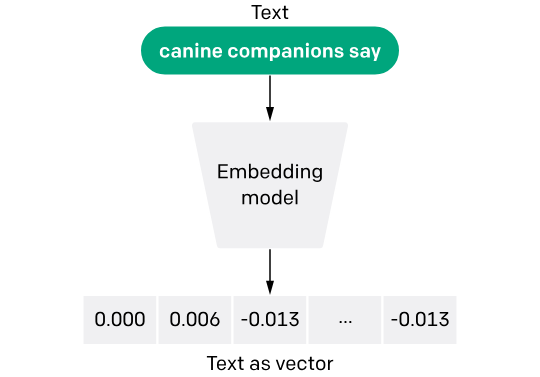

In [ ]:
from langchain_openai import OpenAIEmbeddings

# To authenticatee with server, it usres the API from the env variable `OPENAI_API_KEY`
embeddings = OpenAIEmbeddings()

In [ ]:
sentence1 = "I likes dogs."
sentence2 = "I likes cannies."
sentence3 = "The weather is bad outside."
sentence4 = "I live in remote town."

In [ ]:
embedding1 = embeddings.embed_query(sentence1)
embedding2 = embeddings.embed_query(sentence2)
embedding3 = embeddings.embed_query(sentence3)
embedding4 = embeddings.embed_query(sentence4)

### Similarity Between Embeddings

There are many metrics to calculate the similarity between vectors in a vector space. Some of the most popular similarity metrics today are:

1. **Euclidean Distance** measures the magnitude of the distance between the endpoints of the vectors. One of the main reasons to use Euclidean distance is when your vectors have different magnitudes. In this case, we primarily care about how far apart words are in space, or their semantic distance. A shorter distance means the vectors are more similar.

2. **Cosine Similarity** measures the angle between the vectors. The main focus of cosine similarity is the difference in semantic orientation. When working with normalized vectors, cosine similarity is equivalent to the inner product.

3. **Inner Product** measures the "projection" of one vector onto another. Intuitively, it assesses both the distance and angles between vectors. The larger the angle between two vectors, the smaller the inner product. It also scales with the length of the smaller vector. Therefore, we use the inner product when we care about both orientation and distance. It is suitable for both normalized and non-normalized datasets, and it is a faster and more flexible option than cosine similarity.

Inner Product does not follow the triangular inequality. Larger lengths (large magnitudes) are prioritized. This means we should be careful when using it with Inverted File Index or Graph Index like HSWN.

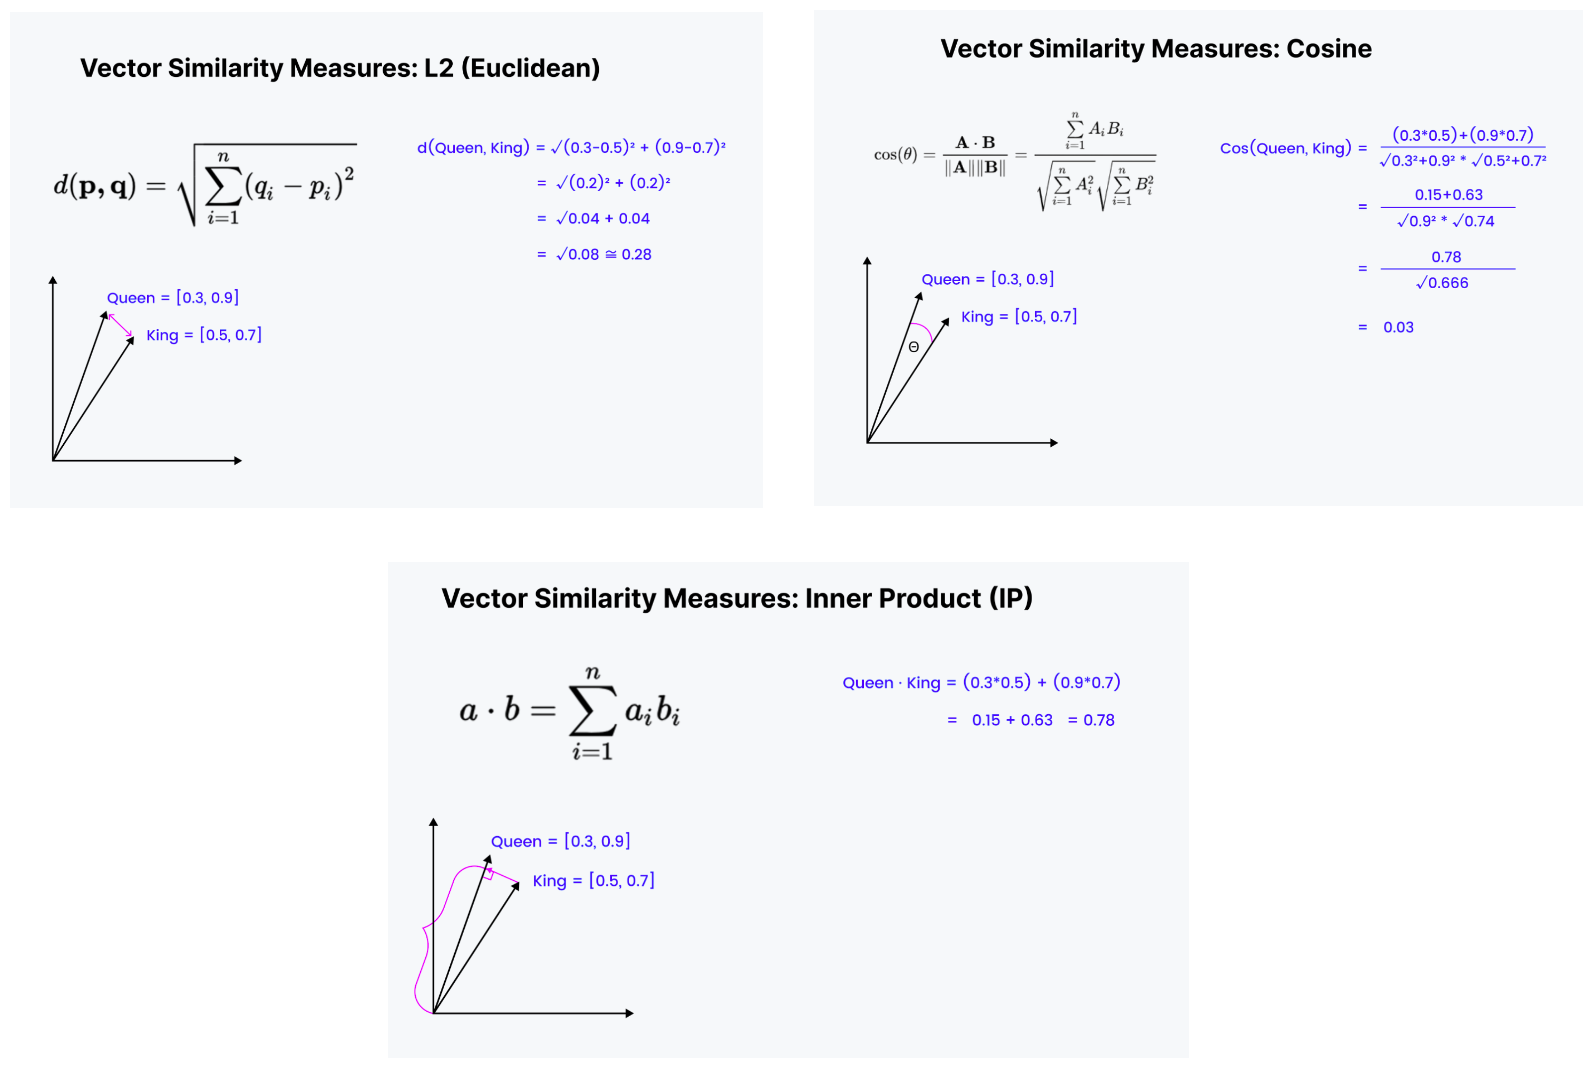


To calculate similarity, you can take the dot product between two embeddings. A **larger dot product value indicates that the sentences are more similar.**

In [ ]:
import numpy as np

# sentence1 and sentence2 are similar so they should score higher
np.dot(embedding1, embedding2)

0.8586403288614753

In [ ]:
# sentence 1 , 3 and 4 are different in sematic meaning, So dot product should be lower
print(">>> Dot product between sentence 1 and 3= ",  np.dot(embedding1, embedding3))
print(">>> Dot product between sentence 1 and 4= ", np.dot(embedding1, embedding4))

>>> Dot product between sentence 1 and 3=  0.7693277758700063
>>> Dot product between sentence 1 and 4=  0.7703195592154594


### Vector Stores

A vector store is a database designed to store vector embeddings and query the database based on similarity scores.

LangChain offers many vector store integrations.

To learn more about the different vector stores available, refer to the [LangChain documentation](https://python.langchain.com/v0.1/docs/integrations/vectorstores/).

In [ ]:
# lets use chromadb as vectorstore for demo
%pip install chromadb -q

In [ ]:
from langchain_community.vectorstores import Chroma


# make a persistent dic for Chromadb so that it donot get removed if we exit the problem
persist_directory = "chromadb/"

In [ ]:
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    # chromadb is automatically persisted in latest update
    persist_directory=persist_directory
)

# display the collection counts of vector embedding
print(vectordb._collection.count())

418


### Similarity Search

In [ ]:
question = "is there an email i can ask for help"
docs = vectordb.similarity_search_with_relevance_scores(question, k=3)

print(">>> Total docs retrived: ", len(docs))
print(">>> Page content: ", docs[0][0].page_content)
print(">>> Metadata: ", docs[0][0].metadata)
print(">>> Relevance score: ", docs[0][1])

>>> Total docs retrived:  3
>>> Page content:  cs229-qa@cs.stanford.edu. This goes to an acc ount that's read by all the TAs and me. So 
rather than sending us email individually, if you send email to this account, it will 
actually let us get back to you maximally quickly with answers to your questions.  
If you're asking questions about homework probl ems, please say in the subject line which 
assignment and which question the email refers to, since that will also help us to route 
your question to the appropriate TA or to me  appropriately and get the response back to 
you quickly.  
Let's see. Skipping ahead — let's see — for homework, one midterm, one open and term 
project. Notice on the honor code. So one thi ng that I think will help you to succeed and 
do well in this class and even help you to enjoy this cla ss more is if you form a study 
group.  
So start looking around where you' re sitting now or at the end of class today, mingle a 
little bit and get to know your classma

### Failure Modes

While similarity search can effectively cover about 80% of our requirements, there are potential failure modes to be aware of.

Here are some edge cases that may arise:

1. **Duplicate Documents**: When we have duplicated documents loaded and split, the search might retrieve both when querying with `k=2` if they have higher relevance scores. For example, if the index contains multiple instances of `MachineLearning-Lecture01.pdf`, duplicate chunks can be retrieved.

2. **Lack of Diversity**: Semantic search fetches all similar documents based on relevance, but it does not enforce diversity. This means that `docs[0]` and `docs[1]` could be identical, resulting in a lack of varied information being retrieved.

In [ ]:
question = "What did they say about matlab?"
docs = vectordb.similarity_search(question, k=5)

print(docs[0])
print("------------------- Both retrived docs are same -----------------")
print(docs[1])

page_content='those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people call it a free ve rsion of MATLAB, which it sort  of is, sort of isn\'t.  \nSo I guess for those of you that haven\'t s een MATLAB before, and I know most of you \nhave, MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to \nplot data. And it\'s sort of an extremely easy to  learn tool to use for implementing a lot of \nlearning algorithms.  \nAnd in case some of you want to work on your  own home computer or something if you \ndon\'t have a MATLAB license, for the purposes of  this class, there\'s also — [inaudible] \nwrite that down [inaudible] MATLAB — there\' s also a software package called Octave \nthat you can download for free off the Internet. And it has somewhat fewer features than MATLAB, but it\'s free, and for the purposes of  this class, it will 

In [ ]:
# see all the sources of the retrived docs
for doc in docs:
  print(doc.metadata)

{'page': 8, 'source': '/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf'}
{'page': 8, 'source': '/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf'}
{'page': 8, 'source': '/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf'}
{'page': 8, 'source': '/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf'}
{'page': 8, 'source': '/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf'}


## Retrieval

Retrieval involves accessing or indexing the data stored in a vector repository. This process encompasses several techniques to find relevant information efficiently:
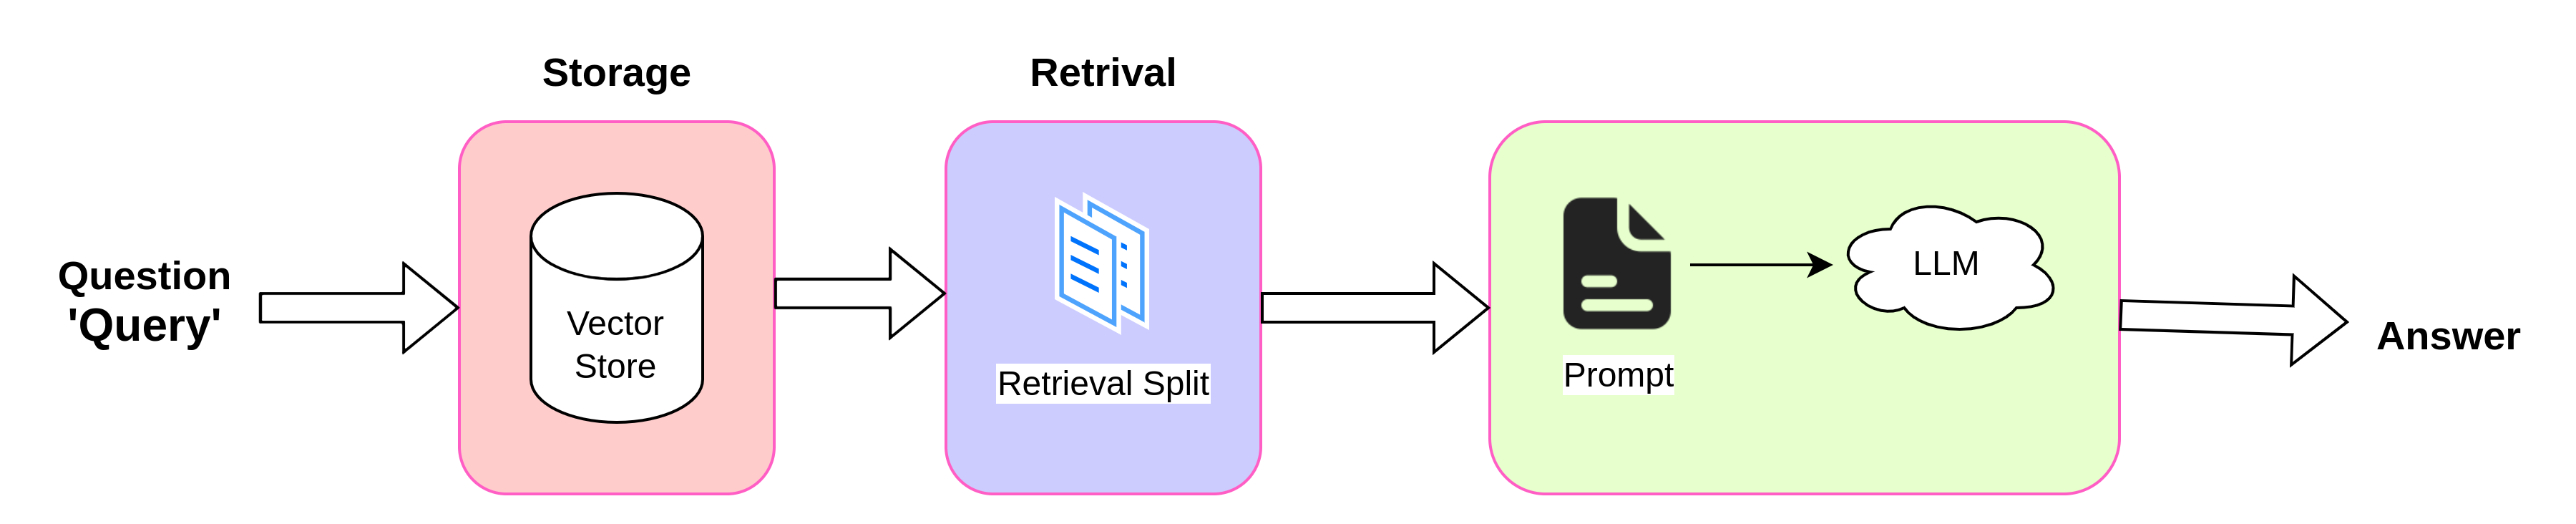

- **Basic Semantic Similarity (Default Behavior):** Utilizes the inherent semantic similarities encoded in the vector representations to retrieve relevant data.
  
- **Maximum Marginal Relevance:** Enhances retrieval by considering both relevance and diversity in the retrieved results, thus preventing redundancy and ensuring a more comprehensive selection.

- **Including Metadata:** Incorporates additional contextual information, such as metadata associated with the text, to refine the retrieval process and provide more accurate results.

- **LLM-Aided Retrieval:** Leveraging Language Model assistance to enhance the retrieval process by utilizing advanced natural language processing capabilities to understand user queries better and retrieve more relevant information accordingly.

### Maximum Marginal Relevance:
This process involves identifying examples whose embeddings exhibit the highest cosine similarity with the inputs. Subsequently, these examples are incrementally incorporated while discouraging their proximity to previously selected ones.

- Retrieve the vector representation of the query.
- Select the `fetch_k` most similar responses.
- Among these responses, pick the `k` most diverse ones.

The maximum marginal relevance algorithm can be expressed as follows:

$$ \text{MMR} = \arg \max_{d_i \in D \setminus R} \left[ \lambda \cdot \text{Sim}_1(d_i, q) - (1 - \lambda) \cdot \max_{d_j \in R} \text{Sim}_2(d_i, d_j) \right] $$

Here, $ D $ represents the set of all candidate documents, $ R $ denotes the set of already selected documents, $ q $ is the query, $ \text{Sim}_1 $ is the similarity function between a document and the query, and $ \text{Sim}_2 $ is the similarity function between two documents. $ d_i $ and $ d_j $ are documents in $ D $ and $ R $ respectively.

The parameter $ \lambda $ (mmr_threshold) determines the trade-off between relevance (the first term) and diversity (the second term). A higher $ \lambda $ places more emphasis on relevance, whereas a lower $ \lambda $ prioritizes diversity.


More on [Llama Index documentation](https://docs.llamaindex.ai/en/stable/examples/vector_stores/SimpleIndexDemoMMR/)

In [ ]:
texts = [
    """The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).""",
    """A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.""",
    """A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.""",
]

In [ ]:
smalldb = Chroma.from_texts(texts, embeddings)

In [ ]:
question = "Tell me about all-white mushrooms with large fruiting bodies"

In [ ]:
print("***** Basic Retrival Techniques *******")
smalldb.similarity_search(question, k=2)

***** Basic Retrival Techniques *******


[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(page_content='The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).')]

In [ ]:
print("***** Retrival using MMR ******")
smalldb.max_marginal_relevance_search(question,k=2, fetch_k=3)

***** Retrival using MMR ******


[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(page_content='A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.')]

In [ ]:
question = "what did they say about matlab?"
docs_ss = vectordb.similarity_search(question, k=3)

print(">>> RETRIVED_DOCS1: ", docs_ss[0].page_content[:100])
print(">>> RETRIVED_DOCS2: ", docs_ss[1].page_content[:100])

>>> RETRIVED_DOCS1:  those homeworks will be done in either MATLA B or in Octave, which is sort of — I 
know some people 
>>> RETRIVED_DOCS2:  those homeworks will be done in either MATLA B or in Octave, which is sort of — I 
know some people 


In [ ]:
# answer is diverse in the mmr retrival
docs_mmr = vectordb.max_marginal_relevance_search(question, k=3)

print(">>> RETRIVED_DOCS1: ", docs_mmr[0].page_content[:100])
print(">>> RETRIVED_DOCS2: ", docs_mmr[1].page_content[:100])

>>> RETRIVED_DOCS1:  those homeworks will be done in either MATLA B or in Octave, which is sort of — I 
know some people 
>>> RETRIVED_DOCS2:  into his office and he said, "Oh, professo r, professor, thank you so much for your 
machine learnin


### LLM Aided Retrieval

1. **Enhanced Query Application**:
   - The query applied to the database often goes beyond the original question asked by the user.
  
2. **SelfQuery Technique**:
   - Involves using a Large Language Model (LLM) to transform the user's question into a more effective database query.
  
3. **Conversion Process**:
   - The LLM interprets the user question and converts it into a query that can retrieve the most relevant information from the database.

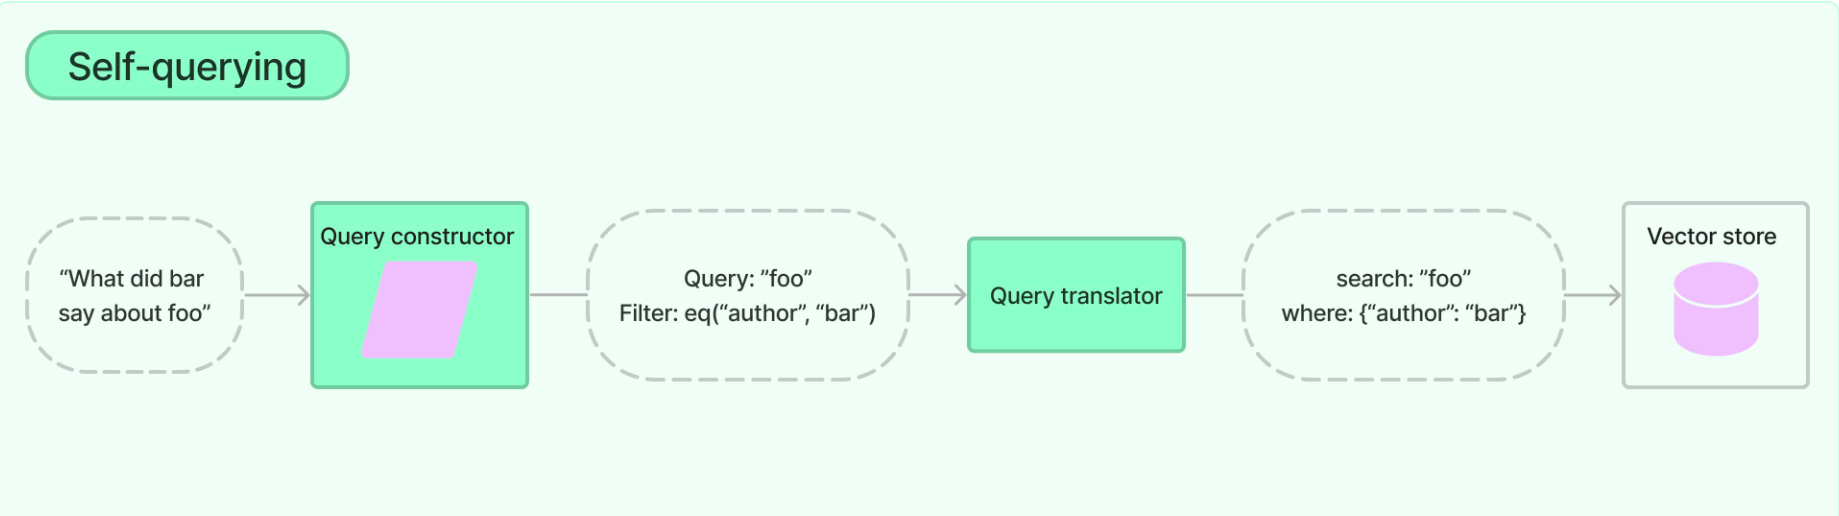

More about implemetation details in [Lnagchain documentation](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/self_query/)


### Addressing Specificity: Working with Metadata

In the previous retrieval example, we demonstrated that a question from the third lecture (or in your case, specific documents, headers, or chapters) can retrieve documents from other lectures.

To address this issue, many vector stores support operations on `metadata`.

`Metadata` provides context for each embedded chunk, helping to ensure more precise and relevant retrievals.

In [ ]:
question = "what did they say about regression in the third lecture?"

# retrive by filtering against metadata
docs = vectordb.similarity_search(
    question,
    k=3,
    filter={"source": "/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf"}
)

for d in docs:
  print(d.metadata)

{'page': 8, 'source': '/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf'}
{'page': 8, 'source': '/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf'}
{'page': 8, 'source': '/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf'}


### Addressing Specificity: Working with Metadata Using Self-Query Retriever

An interesting challenge arises when we need to infer metadata directly from the query. This is particularly useful when we don't want to hardcode the metadata for each query.

To address this, we can use `SelfQueryRetriever`, which leverages a large language model (LLM) to extract:

1. The `query` string for vector search
2. A metadata filter to apply

Most vector databases support metadata filters, so this approach doesn't require new databases or indexes.

In [ ]:
# for selfquering . Useful for parsing the grammer
%pip install lark -q

In [ ]:
from langchain_openai import OpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [ ]:
metadata_info_field = [
    AttributeInfo(
        name="source",
        description="The lecture the chunk is from, should be one of `/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf`, `/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture02.pdf`, or `/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture03.pdf`",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the lecture",
        type="integer"
    )
]

In [ ]:
document_content_description = "Lecture notes"
llm = OpenAI(temperature=0)

retriever = SelfQueryRetriever.from_llm(
    llm,
    vectordb,
    document_content_description,
    metadata_info_field,
    verbose=True
)

In [ ]:
question = "What did they say about regression in teh third lecture?"
for d in docs:
    print(d.metadata)

{'page': 8, 'source': '/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf'}
{'page': 8, 'source': '/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf'}
{'page': 8, 'source': '/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf'}


### Compression

- **Definition**: A technique that increases the number of results included in the context by shrinking the responses to only the relevant information. Passing that full document through your application can lead to more expensive LLM calls and poorer responses.
  
- **Advantages**: Allows more comprehensive responses by incorporating a greater number of context documents.

- **Considerations**: May involve increased computational overhead and cost.

- **Use Cases**: Particularly useful when responses require extensive context from multiple documents.

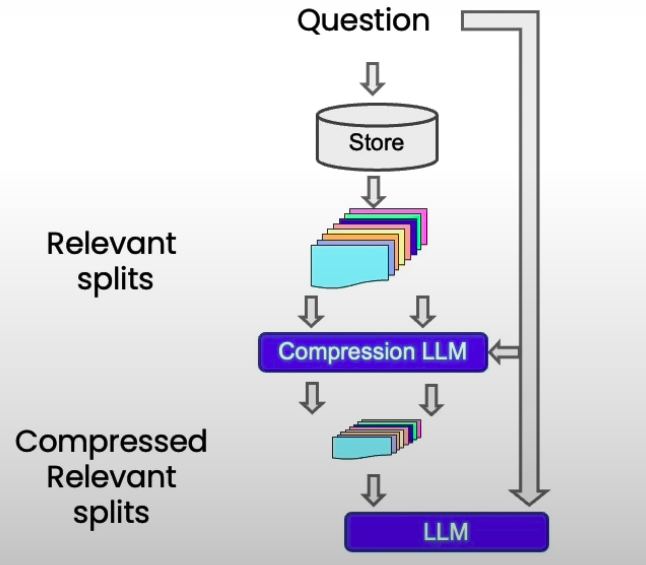

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

In [ ]:
compressor = LLMChainExtractor.from_llm(llm)

In [ ]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))


In [ ]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.invoke(question)
pretty_print_docs(compressed_docs)

Document 1:

- "those homeworks will be done in either MATLA B or in Octave"
- "I know some people call it a free ve rsion of MATLAB"
- "MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to plot data."
- "there's also a software package called Octave that you can download for free off the Internet."
- "it has somewhat fewer features than MATLAB, but it's free, and for the purposes of this class, it will work for just about everything."
- "once a colleague of mine at a different university, not at Stanford, actually teaches another machine learning course."
----------------------------------------------------------------------------------------------------
Document 2:

"Oh, it was the MATLAB."
----------------------------------------------------------------------------------------------------
Document 3:

- All the homeworks can be done in MATLAB or Octave
- The program pre

### Combining various techniques

In [ ]:
# combine context compression with mmr retrival
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever(search_type = "mmr")
)

In [ ]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

Document 1:

- "those homeworks will be done in either MATLA B or in Octave"
- "I know some people call it a free ve rsion of MATLAB"
- "MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to plot data."
- "there's also a software package called Octave that you can download for free off the Internet."
- "it has somewhat fewer features than MATLAB, but it's free, and for the purposes of this class, it will work for just about everything."
- "once a colleague of mine at a different university, not at Stanford, actually teaches another machine learning course."
----------------------------------------------------------------------------------------------------
Document 2:

"Oh, it was the MATLAB."
----------------------------------------------------------------------------------------------------
Document 3:

- All the homeworks can be done in MATLAB or Octave
- The program pre

#### Other types of retrieval

It's worth noting that vectordb as not the only kind of tool to retrieve documents.

The `LangChain` retriever abstraction includes other ways to retrieve documents, such as TF-IDF or SVM.

In [ ]:
from langchain.retrievers import SVMRetriever
from langchain.retrievers import TFIDFRetriever
from langchain.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [ ]:
# Load PDF
loader = PyPDFLoader("/content/files-collection/pdf/cs229_lectures/MachineLearning-Lecture01.pdf")
pages = loader.load()
all_page_text=[p.page_content for p in pages]
joined_page_text=" ".join(all_page_text)

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1500,chunk_overlap = 150)
splits = text_splitter.split_text(joined_page_text)

In [ ]:
# Retrieve
svm_retriever = SVMRetriever.from_texts(splits, embeddings)
tfidf_retriever = TFIDFRetriever.from_texts(splits)

In [ ]:
question = "What are major topics for this class?"
docs_svm=svm_retriever.invoke(question)
docs_svm[0]

Document(page_content="let me just check what questions you have righ t now. So if there are no questions, I'll just \nclose with two reminders, which are after class today or as you start to talk with other \npeople in this class, I just encourage you again to start to form project partners, to try to \nfind project partners to do your project with. And also, this is a good time to start forming \nstudy groups, so either talk to your friends  or post in the newsgroup, but we just \nencourage you to try to star t to do both of those today, okay? Form study groups, and try \nto find two other project partners.  \nSo thank you. I'm looking forward to teaching this class, and I'll see you in a couple of \ndays.   [End of Audio]  \nDuration: 69 minutes")

In [ ]:
question = "what did they say about matlab?"
docs_tfidf = tfidf_retriever.invoke(question)
docs_tfidf[0]

Document(page_content="Saxena and Min Sun here did, wh ich is given an image like this, right? This is actually a \npicture taken of the Stanford campus. You can apply that sort of cl ustering algorithm and \ngroup the picture into regions. Let me actually blow that up so that you can see it more \nclearly. Okay. So in the middle, you see the lines sort of groupi ng the image together, \ngrouping the image into [inaudible] regions.  \nAnd what Ashutosh and Min did was they then  applied the learning algorithm to say can \nwe take this clustering and us e it to build a 3D model of the world? And so using the \nclustering, they then had a lear ning algorithm try to learn what the 3D structure of the \nworld looks like so that they could come up with a 3D model that you can sort of fly \nthrough, okay? Although many people used to th ink it's not possible to take a single \nimage and build a 3D model, but using a lear ning algorithm and that sort of clustering \nalgorithm is the first ste